## Import Packages

In [139]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
import pydotplus
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.cluster import KMeans
from sklearn import tree
from datetime import datetime
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Load and Process Data

In [4]:
def read_data(filename):
	'''
	Convert csv file to a pandas dataframe
	Input: filename (str)
	'''
	data = pd.read_csv(filename)

	return data

'''
Convert datatypes
'''
def convert_type(data, colname, target_type):
	'''
	Convert datatype of a column
	Input: data (dataframe), colname (str), type (str)
	'''
	data[colname] = data[colname].astype(target_type)

'''
Check if the column contains NULLs
'''
def if_null(data, colname):
	'''
	Input: data(dataframe)，colname(str)
	'''
	return data[colname].isnull().values.any()

'''
Find the distribution of a variable in the dataset
'''
def describe_data(data, colname):
	'''
	Input: data(dataframe), colname(str)
	'''
	return data[colname].describe()

'''
Make the boxplot of a variable in the dataset
'''
def boxplot(data, colname):
	'''
	Input: data(dataframe), colname(str)
	'''
	return data[colname].plot.box()

'''
Make the density plot of a variable in the dataset
'''
def density_plot(data, colname):
	'''
	Input: data(dataframe), colname(str)
	'''
	return data[colname].plot.density()

'''
Find summaries of all variables that we are interested in
'''
def find_summaries(data, colnames):
	'''
	Input: data(dataframe), colnames (list)
	'''
	return data[colnames].describe()

'''
Find correlations between variables
'''
def find_corr(data, col1, col2):
	'''
	Input: data(dataframe). col1(str), col2(str)
	'''
	return data[col1].corr(data[col2])

'''
Discretize a set of columns in a dataset
'''
def discretize_col(data, columns, bins, labels):
    '''
    To discretize the continuous variable into various discrete variables: 0, 1, and 2
    
    Inputs: data, pandas dataframe
            columns, list
            bins, list
            labels, list
    '''
    for column in columns:
    	data[column] = pd.cut(data[column], bins=bins, labels=labels, include_lowest=True)
'''
Fill in NA values with mean
'''
def fill_na(data, columns):
	'''
	Input: data, pandas dataframe
	       columns, list
	'''
	for column in columns:
		if data[column].isnull().any():
			data[column] = data[column].fillna(data[column].median())

'''
Convert the label to dummy variables
'''
def label_to_dummy(item, bar):
    '''
    item: int
    bar: int
    '''
    if item >= bar:
        result = 1
    else:
        result = 0
    return result

'''
Convert columns in categorical variables to dummy variables
'''
def to_dummy(data, column):
    '''
    data, pandas dataframe
    column, list
    '''
    data = pd.get_dummies(data, columns=column)
    
    return data

## K Means Clustering

In [89]:
def create_clustering_model(X, k):
    
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    
    return kmeans, y_kmeans


def create_cluster_map(X, kmeans):
    
    cluster_map = pd.DataFrame()
    for index, colname in enumerate(list(X)):
        cluster_map[colname] = X[colname]
    cluster_map['cluster_label'] = kmeans.labels_
    
    return cluster_map


def find_summary_stats_of_cluster(cluster_map, label):
    
    cluster = cluster_map[cluster_map['cluster_label'] == label]
    
    return find_summaries(cluster, cluster.columns)


def describe_data_in_cluster_using_boxplot(cluster_map, label):
    
    cluster = cluster_map[cluster_map['cluster_label'] == label]
    
    return cluster.plot.box()


def describe_data_in_cluster_using_density(cluster_map, label):
    
    cluster = cluster_map[cluster_map['cluster_label'] == label]

    return cluster.plot.density()


## Find Distinctive Features in Cluster Using Decision Tree

In [28]:
def create_decision_tree(X, features, label):
    
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X[features], X[label])
    
    return clf


def visualize_tree(tree, filename, feature_names, label_names):
    
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,feature_names = feature_names, class_names=label_names)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_png(filename)

## Merge, Split, and Re-cluster

In [37]:
def merge_clusters(cluster_map, to_be_merged_labels, new_label):
    
    cluster_map['cluster_label'].replace(to_be_merged_labels, label)
    
    return cluster_map


def split_clusters(cluster_map, label_to_be_splited, split_number):
    
    to_be_splited = cluster_map[cluster_map['cluster_label'] == label_to_be_splited]
    X = to_be_splited[to_be_splited.columns[:-1]]
    new_k_means = KMeans(n_clusters=split_number)
    new_k_means.fit(X)
    new_cluster_map = pd.DataFrame()
    for index, colname in enumerate(list(X)):
        new_cluster_map[colname] = X[colname]
    new_cluster_map['cluster_label'] = new_kmeans.labels_
    
    return new_cluster_map


def re_cluster(cluster_map, k):
    
    X = cluster_map[cluster_map.columns[:-1]]
    new_kmeans, new_ykmeans = create_clustering_model(X, k)
    
    return new_kmeans, new_ykmeans

## Analysis Part

In [49]:
data = pd.read_csv('projects.csv')
data['date_posted'] = data['date_posted'].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))
data['datefullyfunded'] = data['datefullyfunded'].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))
data['over_60_days'] = data['datefullyfunded'] - data['date_posted']
data['over_60_days'] = data['over_60_days'].apply(lambda x: x.days)
data['over_60_days'] = data.apply(lambda row: label_to_dummy(row['over_60_days'], 60), axis=1)

In [54]:
data.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_metro', 'school_district', 'school_county', 'school_charter',
       'school_magnet', 'teacher_prefix', 'primary_focus_subject',
       'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'grade_level',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'date_posted', 'datefullyfunded',
       'over_60_days'],
      dtype='object')

In [71]:
features = ['school_metro', 'poverty_level', 'total_price_including_optional_support']
for colname in features:
    if if_null(data, colname):
        data.dropna(subset=[colname], inplace=True)
data['poverty_level'].unique()

array(['highest poverty', 'high poverty', 'low poverty',
       'moderate poverty'], dtype=object)

In [69]:
data['school_metro_feature'] = data['school_metro'].replace(['urban', 'suburban', 'rural'], [0,1,2])

In [73]:
data['poverty_level_feature'] = data['poverty_level'].replace(['low poverty', 'moderate poverty', 
                                                               'high poverty', 'highest poverty'], [0,1,2,3])

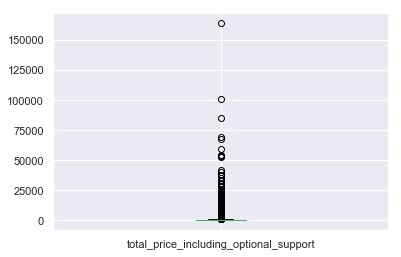

In [75]:
data['total_price_including_optional_support'].plot.box()

In [116]:
to_be_discretized = 'total_price_including_optional_support'
data['total_price_feature'] = pd.cut(data[to_be_discretized], bins=[data[to_be_discretized].min(), data[to_be_discretized].quantile(0.25), data[to_be_discretized].quantile(0.75),
                                              	data[to_be_discretized].max()], labels=[0,1,2], include_lowest=True)
data['total_price_feature'] = data['total_price_feature'].astype('float')

In [117]:
new_features = ['school_metro_feature', 'poverty_level_feature', 'total_price_feature']
to_be_observed = new_features + ['over_60_days']

In [118]:
X = data[new_features]
kmeans, y_kmeans = create_clustering_model(X, 3)
cluster_map = create_cluster_map(X, kmeans)
cluster_map

,school_metro_feature,poverty_level_feature,total_price_feature,cluster_label
0,0,3,2.0,2
1,0,3,0.0,0
2,0,2,2.0,2
3,0,2,0.0,0
4,1,2,2.0,1
5,0,3,1.0,2
6,2,2,1.0,1
7,0,3,2.0,2
8,0,2,2.0,2
9,1,3,2.0,2


In [119]:
find_summary_stats_of_cluster(cluster_map, 0)
# Cluster 0: Projects that mainly come from schools in suburban area with relatively high poverty level, 
# and the total price is relatively low to medium

,school_metro_feature,poverty_level_feature,total_price_feature,cluster_label
count,32774.000000,32774.000000,32774.000000,32774.0
mean,0.737231,2.776469,0.297370,0.0
std,0.734049,0.416617,0.457108,0.0
min,0.000000,2.000000,0.000000,0.0
25%,0.000000,3.000000,0.000000,0.0
50%,1.000000,3.000000,0.000000,0.0
75%,1.000000,3.000000,1.000000,0.0
max,2.000000,3.000000,1.000000,0.0


In [120]:
find_summary_stats_of_cluster(cluster_map, 1)
# Cluster 1: Projects that mainly come from schools in suburban & rural areas with moderate-to-high poverty level,
# and the total price is relatively medium-to-high

,school_metro_feature,poverty_level_feature,total_price_feature,cluster_label
count,31023.000000,31023.000000,31023.000000,31023.0
mean,1.032137,1.262096,1.163943,1.0
std,0.684027,0.628598,0.649141,0.0
min,0.000000,0.000000,0.000000,1.0
25%,1.000000,1.000000,1.000000,1.0
50%,1.000000,1.000000,1.000000,1.0
75%,2.000000,2.000000,2.000000,1.0
max,2.000000,2.000000,2.000000,1.0


In [121]:
find_summary_stats_of_cluster(cluster_map, 2)
# Cluster 2: Projects that mainly come from schools in urban areas with high poverty level,
# and the total price is medium-to-high.

,school_metro_feature,poverty_level_feature,total_price_feature,cluster_label
count,45955.000000,45955.000000,45955.000000,45955.0
mean,0.124121,2.774410,1.390425,2.0
std,0.388726,0.417975,0.487851,0.0
min,0.000000,2.000000,1.000000,2.0
25%,0.000000,3.000000,1.000000,2.0
50%,0.000000,3.000000,1.000000,2.0
75%,0.000000,3.000000,2.000000,2.0
max,2.000000,3.000000,2.000000,2.0


In [129]:
X_2 = data[to_be_observed]
X_2 = data[to_be_observed][data[to_be_observed]['over_60_days'] == 1]
kmeans, y_kmeans = create_clustering_model(X_2[X_2.columns[:-1]], 3)
cluster_map_2 = create_cluster_map(X_2[X_2.columns[:-1]], kmeans)
cluster_map_2

,school_metro_feature,poverty_level_feature,total_price_feature,cluster_label
2,0,2,2.0,2
4,1,2,2.0,2
5,0,3,1.0,0
10,1,0,0.0,2
11,1,1,1.0,2
14,0,3,1.0,0
16,1,2,1.0,2
23,1,3,2.0,0
25,0,3,1.0,0
26,2,2,1.0,1


In [130]:
find_summary_stats_of_cluster(cluster_map_2, 0)
# Cluster 0: Projects that come from schools located in urban/suburban areas with highest poverty level, and total price
# is medium-to-high

,school_metro_feature,poverty_level_feature,total_price_feature,cluster_label
count,14598.000000,14598.0,14598.000000,14598.0
mean,0.291615,3.0,1.277983,0.0
std,0.454522,0.0,0.641124,0.0
min,0.000000,3.0,0.000000,0.0
25%,0.000000,3.0,1.000000,0.0
50%,0.000000,3.0,1.000000,0.0
75%,1.000000,3.0,2.000000,0.0
max,1.000000,3.0,2.000000,0.0


In [131]:
find_summary_stats_of_cluster(cluster_map_2, 1)
# Projects that come from schools located in rural area with relatively high poverty level, and total price is medium-to-high

,school_metro_feature,poverty_level_feature,total_price_feature,cluster_label
count,5071.0,5071.000000,5071.000000,5071.0
mean,2.0,2.043187,1.131729,1.0
std,0.0,0.815958,0.662612,0.0
min,2.0,0.000000,0.000000,1.0
25%,2.0,1.000000,1.000000,1.0
50%,2.0,2.000000,1.000000,1.0
75%,2.0,3.000000,2.000000,1.0
max,2.0,3.000000,2.000000,1.0


In [132]:
find_summary_stats_of_cluster(cluster_map_2, 2)
# Projects that come from schools located in urban/suburban areas with moderate poverty level, and total price is medium-to-high

,school_metro_feature,poverty_level_feature,total_price_feature,cluster_label
count,11535.000000,11535.000000,11535.000000,11535.0
mean,0.489033,1.529345,1.245427,2.0
std,0.499901,0.612837,0.647667,0.0
min,0.000000,0.000000,0.000000,2.0
25%,0.000000,1.000000,1.000000,2.0
50%,0.000000,2.000000,1.000000,2.0
75%,1.000000,2.000000,2.000000,2.0
max,1.000000,2.000000,2.000000,2.0


### Top 5% of Predicted Projects Unlikely to be Fully Funded

From last homework, we recognized that the logistic regression model is the best model on predicting the projects that are not likely to be fully funded in 60 days. As a result, we use logistic regression model here to find the top 5% of the projects unlikely to be fully funded in 60 days

In [229]:
data_to_train = data[to_be_observed]
X = data_to_train[['school_metro_feature', 'poverty_level_feature', 'total_price_feature']]
y = data_to_train['over_60_days']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = LogisticRegression(penalty='l2',C=1.0, solver='lbfgs')
clf = clf.fit(X_train, y_train)
y_pred_probs = clf.predict_proba(X_test)[:,1]

In [230]:
pred_probs_map = pd.DataFrame()
pred_probs_map['index'] = y_test.index
pred_probs_map['probs'] = y_pred_probs
pred_probs_map = pred_probs_map.sort_values(by='probs',ascending=False)
pred_probs_map = pred_probs_map[:int(len(y_test)*0.05)]
pred_probs_map

,index,probs
33232,74367,0.524592
28157,111689,0.524592
17588,14821,0.524592
35241,57599,0.524592
25772,110007,0.524592
19981,97908,0.524592
6524,118743,0.524592
27979,78465,0.524592
17614,55270,0.524592
36024,42990,0.524592


In [231]:
indices_lst = []
for index in pred_probs_map['index']:
    indices_lst.append(index)
X_to_be_examined = X_test[X_test.index.isin(indices_lst)]
X_to_be_examined

,school_metro_feature,poverty_level_feature,total_price_feature
48877,2,3,2.0
93393,1,1,2.0
102633,2,2,2.0
8323,2,1,2.0
29133,2,2,2.0
3423,2,3,2.0
83025,2,3,2.0
79289,1,1,2.0
68279,1,1,2.0
69061,1,0,2.0


In [232]:
kmeans, y_kmeans = create_clustering_model(X_to_be_examined, 3)
cluster_map = create_cluster_map(X_to_be_examined, kmeans)
cluster_map

,school_metro_feature,poverty_level_feature,total_price_feature,cluster_label
48877,2,3,2.0,1
93393,1,1,2.0,0
102633,2,2,2.0,1
8323,2,1,2.0,2
29133,2,2,2.0,1
3423,2,3,2.0,1
83025,2,3,2.0,1
79289,1,1,2.0,0
68279,1,1,2.0,0
69061,1,0,2.0,0


In [233]:
find_summary_stats_of_cluster(cluster_map, 0)
#Cluster 0: suburban schools, moderate poverty level, high total price

,school_metro_feature,poverty_level_feature,total_price_feature,cluster_label
count,819.0,819.000000,819.0,819.0
mean,1.0,0.774115,2.0,0.0
std,0.0,0.418419,0.0,0.0
min,1.0,0.000000,2.0,0.0
25%,1.0,1.000000,2.0,0.0
50%,1.0,1.000000,2.0,0.0
75%,1.0,1.000000,2.0,0.0
max,1.0,1.000000,2.0,0.0


In [234]:
find_summary_stats_of_cluster(cluster_map, 1)
# Cluster 1: rural schools, high to extreme high poverty level, high total price

,school_metro_feature,poverty_level_feature,total_price_feature,cluster_label
count,694.0,694.000000,694.0,694.0
mean,2.0,2.455331,2.0,1.0
std,0.0,0.498360,0.0,0.0
min,2.0,2.000000,2.0,1.0
25%,2.0,2.000000,2.0,1.0
50%,2.0,2.000000,2.0,1.0
75%,2.0,3.000000,2.0,1.0
max,2.0,3.000000,2.0,1.0


In [235]:
find_summary_stats_of_cluster(cluster_map, 2)
# Cluster 2: suburban schools, low-to-moderate poverty level, high total price

,school_metro_feature,poverty_level_feature,total_price_feature,cluster_label
count,297.0,297.000000,297.0,297.0
mean,2.0,0.872054,2.0,2.0
std,0.0,0.334594,0.0,0.0
min,2.0,0.000000,2.0,2.0
25%,2.0,1.000000,2.0,2.0
50%,2.0,1.000000,2.0,2.0
75%,2.0,1.000000,2.0,2.0
max,2.0,1.000000,2.0,2.0
